In [1]:
import pandas as pd
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as R2
from sklearn.metrics import mean_squared_error as MSE
from sklearn.multioutput import MultiOutputRegressor
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import reduce

import warnings
warnings.filterwarnings('ignore')

In [2]:
target = 'NEE'

model = ['rcef_RandomForestRegressor', 'rcef_RidgeCV', 'rcef_XGBRegressor', 'xgboost'] 

extracted_features = model[-1]

In [3]:
# loads all data sets into a dict
def load_datasets(dirs: list, load_path: str) -> dict:
    files = ['soil_c','surf_water','flux_soc','soil_water','n_flux','p_flux','temp', 
         'plant_c','plant_n','plant_p','canopcy_c','plant_stress','photosynthesis','plant_growth']
    
    #files.append('soil_temp', 'canopy_temp') missing 
    datasets = {}
    
    for dr in dirs:
        csv_list = []
        path = 'datasets/' + dr + load_path
        for f in files:
            df = pd.read_csv(os.path.join(path,f + '.csv'))
            df.drop(df.columns[0], axis=1)

            csv_list.append(df)


        data_dict = {}
        for i in range (len(csv_list)):
            data_dict[files[i]] = csv_list[i]

        datasets[dr] = data_dict

    return datasets

dirs = ['warm_temp_maize_soybean_irrigated', 'warm_temp_maize-soybean_dryland', 'cool_temp_maize_soybean']

datasets = load_datasets(dirs, '/csv_outs/with_plant_soil_details/')

In [4]:
def rename_dupes(suffix: str, df: pd.DataFrame, dupes: list) -> pd.DataFrame:
    for col in df.columns:
        if col in dupes:
            df.rename(columns={col: col + suffix}, inplace=True)
    return df

def average_numbered_columns(df):
    numbered_cols = [col for col in df.columns if '_' in col and col.split('_')[-1].isdigit()]

    col_groups = {}
    for col in numbered_cols:
        prefix = '_'.join(col.split('_')[:-1])
        if prefix not in col_groups:
            col_groups[prefix] = []
        col_groups[prefix].append(col)

    # calculate averages and add new columns
    for prefix, cols in col_groups.items():
        avg_col_name = prefix
        avg_col_values = df[cols].mean(axis=1)
        df[avg_col_name] = avg_col_values

    # drop numbered columns
    df = df.drop(columns=numbered_cols)

    return df

def nee_cumulative_to_daily(df: pd.DataFrame) -> pd.DataFrame:
    df['DOY'] = df['DOY'].astype(int)

    # Divide only rows with DOY > 0
    df['ECO_NPP'] = df.apply(lambda row: row['ECO_NPP']/row['DOY'] if row['DOY'] != 0 else row['ECO_NPP'], axis=1)
    df['ECO_RH'] = df.apply(lambda row: row['ECO_RH']/row['DOY'] if row['DOY'] != 0 else row['ECO_RH'], axis=1)

    df['NEE'] = df['ECO_NPP'] - df['ECO_RH']
    
    return df

# turn all csv's to one dataframe
def to_pd(df: dict, handle_dupes: bool, flatten_num_cols: bool) -> pd.DataFrame:
    x = pd.DataFrame()
    for file_name in df:
        cur = df[file_name]
            
        x = pd.concat([x, df[file_name]], axis = 1)
        
    cheeky_col = 'unnamed.1'
    cheeky_col2 = 'Unnamed: 0'
    if cheeky_col in x.columns:
        x = x.drop([cheeky_col], axis=1)
    elif cheeky_col2 in x.columns:
         x = x.drop([cheeky_col2], axis=1)
    x = x.drop(['DATE'], axis=1)

    if flatten_num_cols:
        x = average_numbered_columns(x)
        
    x = x.loc[:,~x.columns.duplicated()].copy()
    
    one_hot = pd.get_dummies(x['GROWTH_STG'])
    x= x.drop('GROWTH_STG',axis = 1)
    # Join the encoded df
    x = x.join(one_hot)

    x.columns = x.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))
    
    return x

df_dry = nee_cumulative_to_daily(to_pd(datasets['warm_temp_maize-soybean_dryland'], True, True))
df_irr = nee_cumulative_to_daily(to_pd(datasets['warm_temp_maize_soybean_irrigated'], True, True))
df_cool = nee_cumulative_to_daily(to_pd(datasets['cool_temp_maize_soybean'], True, True))

df = pd.concat([df_dry,df_irr, df_cool])

df['WIND'] = df['WIND'] / 100

y = df[target].copy()

#y = df[target].copy()
#df = df.drop(target, axis=1)

## AmeriFLUX USNE Dataset irrigated maize-soybean, years 2015- 2021

In [7]:
with_obs_feats = 'obsfeats'

### NEE with constant ustar threshold, found by k means 

In [8]:
observed_df = pd.read_csv('datasets/TestTrainextractedNEE_CUT_REF_NIGHT' + with_obs_feats + '.csv')

### NEE with constsant ustar threshold found by cosine similarity

In [7]:
observed_df = pd.read_csv('datasets/extractedNEE_CUT_75_NIGHT' + with_obs_feats + '.csv') 

### NEE with constant ustar threshold measured nightly within the first five soil layers.
#### Found to be ~0.60 linearly correlated using pearson correlation

In [15]:
observed_df = pd.read_csv('datasets/extractedNEE_CUT_05_NIGHT' + with_obs_feats + '.csv')

In [9]:
observed_df['initial planting density (m-2)1'] = 8.2
observed_df['DOY'] = observed_df['DOY'].astype(int)

In [10]:
xgbFeatImp = pd.read_csv('feature_analysis/xgboost/FeaturesImportance'  + target  + 'weather_soil_data' + '.csv')
feat_cols = []
for i in range(len(xgbFeatImp.values)):
    feat_cols.append(xgbFeatImp.values[i][0])

y = df[target].copy()
x = df[feat_cols].copy()

x_observed = observed_df[feat_cols]
y_observed = observed_df[target].copy()

In [11]:
x

,TMAX_AIR,TMAX_SOIL,TMIN_AIR,D_W_PRECN,WIND,HMAX_AIR,HMIN_AIR,TMIN_SOIL,RADN,initial planting density (m-2)1,DOY
0,2.91,4.951854,-2.93,0.0,3.31524,0.630569,0.435766,3.190371,4.710812,6.2,0
1,2.19,4.953446,-5.90,0.0,2.47068,0.630147,0.349557,2.944458,7.255759,6.2,1
2,9.11,5.599835,-6.89,0.0,2.45952,0.796492,0.324438,2.766023,8.689023,6.2,2
3,8.71,5.658164,-0.99,0.7,3.76056,0.897199,0.501948,3.159278,3.999532,6.2,3
4,3.73,4.463433,-4.64,0.0,3.67992,0.702206,0.384053,3.058000,2.409738,6.2,4
...,...,...,...,...,...,...,...,...,...,...,...
2917,0.90,-711.935654,-11.60,0.0,4.03272,0.490577,0.225464,716.425542,5.302800,6.6,360
2918,3.30,-711.953454,-8.10,0.0,4.34232,0.564898,0.317146,716.419829,3.804480,6.6,361
2919,0.70,-711.985770,-8.70,1.2,3.84336,0.633341,0.299815,716.397027,2.213640,6.6,362
2920,-7.60,-712.013117,-24.20,1.6,9.20376,0.321801,0.055784,716.349076,6.843240,6.6,363


In [12]:
for entr in x.columns:
    x[entr] = preprocessing.normalize([x[entr]])[0]
y = pd.Series(preprocessing.normalize([y])[0], name='NEE')

In [13]:
for entr in x_observed.columns:
    x_observed[entr] = preprocessing.normalize([x_observed[entr]])[0]
y_observed = pd.Series(preprocessing.normalize([y_observed])[0], name='NEE')

In [14]:
x = pd.concat([x_observed, x])
y = pd.concat([y_observed, y])

X_train, X_test, y_train, y_test = train_test_split(
   x, y, test_size=0.33, random_state=30)

In [15]:
xgb_r = xg.XGBRegressor()
xgb_r.load_model("models/simulated_with_daily_nee.json")

#### Fit simulated data using hyper params found after gaussian optimization

In [16]:
# Fitting the model
xgb_r.fit(X_train, y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8412302286461404, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float'],
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1617, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [17]:
# Predict the model
pred = xgb_r.predict(X_test)

RMSE :  0.001618


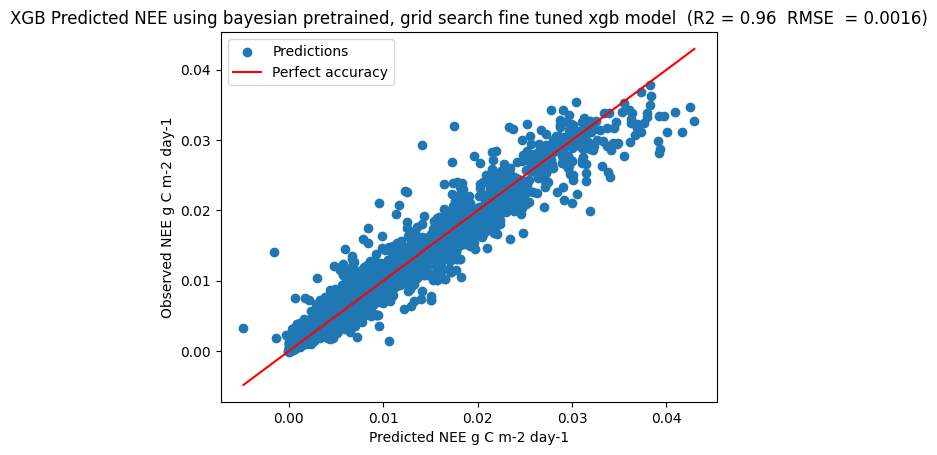

In [18]:
# Calculate R2 score
r2 = R2(y_test, pred)

rmse = np.sqrt(MSE(y_test, pred))
print("RMSE : % f" %(rmse))

# Create scatter plot
plt.scatter(y_test, pred)

# Plot a red line for perfect accuracy
x = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x, x, color='r')

# Add title and legend
plt.title("XGB Predicted " + target +  " using bayesian pretrained, grid search fine tuned xgb model  (R2 = %0.2f  RMSE  = %0.4f)" %  (r2, rmse))
plt.legend(['Predictions', 'Perfect accuracy'], loc='upper left')
plt.xlabel("Predicted NEE g C m-2 day-1")
plt.ylabel("Observed NEE g C m-2 day-1")

#plt.savefig("results/bayesian pretrained, grid search fine tuned xgb model  " + target + "with planting details.png" )
# Show plot
plt.show()

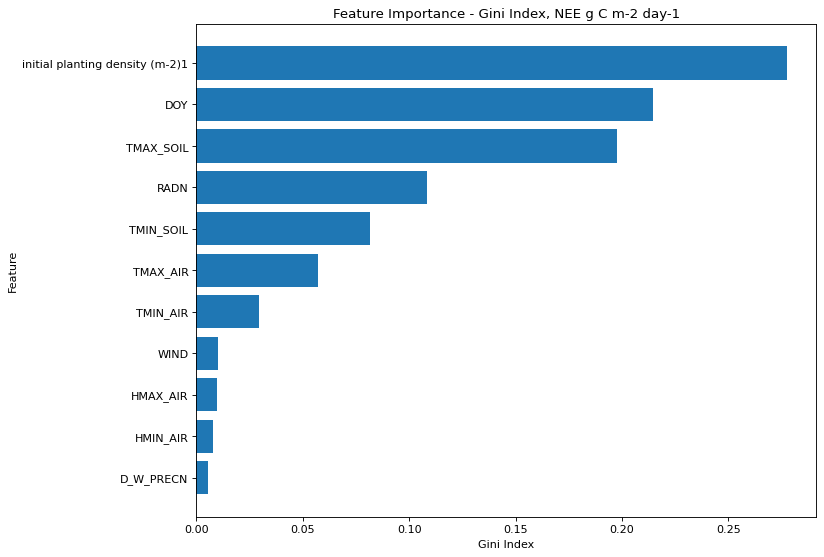

In [19]:
importances = pd.DataFrame({'GINI': xgb_r.feature_importances_}, index=x_observed.columns).sort_values(by='GINI', ascending=True)

# Create a horizontal bar chart
plt.figure(figsize=(10, 8), dpi=80)
plt.barh(importances.index, importances['GINI'])

# Add title and axis labels
plt.title('Feature Importance - Gini Index, NEE g C m-2 day-1')
plt.xlabel('Gini Index')
plt.ylabel('Feature')

#plt.savefig('results/FeatureImportanceGB_sim_data_with_ameriflux_pred' + target + "with_planting_details.png")
# Show the plot
plt.show()

In [30]:
g = importances[importances > 0.0001].dropna()

In [31]:
g

,GINI
D_W_PRECN,0.007345
HMAX_AIR,0.008442
HMIN_AIR,0.011491
TMAX_SOIL,0.012903
TMAX_AIR,0.016649
TMIN_AIR,0.026146
TMIN_SOIL,0.029378
WIND,0.049143
initial planting density (m-2)1,0.184266
RADN,0.307452


In [18]:
os.makedirs('feature_analysis/xgboost', exist_ok=True)  
g.to_csv('feature_analysis/xgboost/FeaturesImportance'  + target  + 'weather_soil_data' + '.csv')  